# eNATL 

In [ ]:
# create a camera path
# Make camera path
pos1 = [-70, 20, 4.0]
pos2 = [40, -35, 3.0]

n_still1 = 10
n_move = 30
n_still2 = 10
n = n_still1 + n_move + n_still2

lon = np.hstack([np.repeat(pos1[0], n_still1), np.linspace(pos1[0], pos2[0], n_move), np.repeat(pos2[0], n_still2)])
lat = np.hstack([np.repeat(pos1[1], n_still1), np.linspace(pos1[1], pos2[1], n_move), np.repeat(pos2[1], n_still2)])
r = np.hstack([np.repeat(pos1[2], n_still1), np.linspace(pos1[2], pos2[2], n_move), np.repeat(pos2[2], n_still2)])

camera_path = lines_from_points(convert_to_xyz(lon, lat, r))

In [1]:
#TODO: Factor these out into a module (WHAT IS THE EASIEST WAY TO DO THAT?) Do I need to build a full blown package?

import os
def check_docker_image(image_tag:str):
    """Assure that the kurrent kernel is running the exact `image_tag` otherwise raise error"""
    spec = os.environ['JUPYTER_IMAGE_SPEC']
    if not spec == image_tag:
        raise ValueError(f"JUPYTER_IMAGE_SPEC environment variable did not match {image_tag=} got {spec}")
    else:
        print(f"Using JUPYTER_IMAGE_SPEC={spec}")

##### viz stuff (should also be factored out)
## camera stuff
def make_points(r,n, xoffset, yoffset, linear, funky, rotation_factor):
    """Helper to make XYZ points"""
    !! I did translate this to lon/lat somewhere at some point, so lets not reuse that
    start = ((2.55 + +0.25) * np.pi)+ np.pi # this is just a fixed position at the end of the rotation. 
    # the camera up gets confused when we are looking straight down. So start at a very slight angle
    rotation = (rotation_factor * np.pi)
    stop = start
    if linear:
        theta = np.linspace(start, stop, n)
    else:
        theta = np.geomspace(start, stop, n)
    if funky:
        # move closer and rotate a bit
        x = np.linspace(0, r/5, n)
        r = np.linspace(r, r*1/2, n)
    else:
        x = np.zeros(n)
    
    y = r * np.cos(theta)
    z = r * np.sin(theta)
    # swap dimensions
    z, x, y = x, y, z
    return np.column_stack((x+xoffset, y+yoffset, z))

def lines_from_points(points):
    """Given an array of points, make a line set"""
    poly = pv.PolyData()
    poly.points = points
    cells = np.full((len(points) - 1, 3), 2, dtype=np.int_)
    cells[:, 1] = np.arange(0, len(points) - 1, dtype=np.int_)
    cells[:, 2] = np.arange(1, len(points), dtype=np.int_)
    poly.lines = cells
    return poly


def orbital_path(r=1e-10,n=100, xoffset=0, yoffset=0, rotation_factor=0, linear=True, funky=False):
    points = make_points(r, n, xoffset, yoffset, linear, funky, rotation_factor)
    line = lines_from_points(points)
    line["scalars"] = np.arange(line.n_points)
    return line

def get_frame(ds, t, subsample, variable, nanmask, x_dim, y_dim, lon_name, lat_name):
    da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
    for co in [lon_name, lat_name]:
        da = da.assign_coords({co:da.coords[co].where(nanmask)})
    da = da[variable]
    return da

def make_mesh(da, lon_name, lat_name):
    lon = da[lon_name]
    lat = da[lat_name]
    mesh = gv.Transform.from_2d(lon, lat, data=da.data)
    # # Remove cells from the mesh with NaN values.
    mesh = mesh.threshold()
    return mesh

def update_mesh(plotter, ds, f, subsample, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name):
    da = get_frame(ds, f, subsample, variable, nanmask, x_dim, y_dim, lon_name, lat_name)
    mesh = make_mesh(da, lon_name, lat_name)
    # sargs = {
    #     # "title": f"{da.name} / {da.units}",
    #     "height":0.25,
    #     "vertical":True,
    #     "position_x":0.05,
    #     "position_y":0.05
    # }
    actor = plotter.add_mesh(
        mesh,
        show_edges=False,
        show_scalar_bar=False,
        # scalar_bar_args=sargs,
        cmap=cmap,
        clim=clim,
        interpolate_before_map=True ######### 🔥 MIGHT AFFECT PERFORMANCE
    )
    return actor

def make_movie(
    ds_movie,
    variable,
    cmap,
    clim,
    filename,
    preview=False,
    x_dim='x',
    y_dim='y',
    lon_name='lon',
    lat_name='lat'
):

    # some checks
    if any(len(ds_movie[co].dims)!=2 for co in [lon_name, lat_name]):
        raise ValueError(f"Expected longitude and latitude coordinates to be 2 dimensional. Got {[(co, list(ds_movie[co].dims)) for co in [lon_name, lat_name]]}")

    # It seems like some of the internal steps (`make_mesh` and in particular gv.Transform.from_2d(lon, lat, data=da.data) seem to assume that)
    # the dimensions are ordered in a certain way! 
    # TODO: Raise an issue and see if we can fix this upstream
    # for now always transpose here
    other_dims = [dim for dim in list(ds_movie.dims) if dim not in ['time', x_dim, y_dim]] #FIXME (also make time generic?)
    ds_movie = ds_movie.transpose(*['x', 'y', 'time']+other_dims)
    
    nanmask = ~np.isnan(ds_movie.isel(time=0)[variable]).reset_coords(drop=True)
    
    if preview:
        pv.global_theme.trame.interactive_ratio = 0.75 #1 or 2 
        pv.global_theme.trame.still_ratio = 4
        subs = 1
        window_size = None
    else:
        #(does this affect the movie quality?)
        pv.global_theme.trame.interactive_ratio = 5 #1 or 2 (does this affect the movie quality?)
        pv.global_theme.trame.still_ratio = 5
        subs = 1
        window_size = ([3840, 2160]) #4k res
        # window_size = ([1920, 1088]) #HD res
    
    
    p = gv.GeoPlotter(
        window_size= window_size,
        lighting='three lights'
    )
    
    # p.add_base_layer(texture=gv.natural_earth_1())
    p.add_base_layer(color='black')
    p.background_color = "black"
    
    # first mesh add
    c = update_mesh(p, ds_movie, 0, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)

    ###### this whole block needs to be provided as an input class that just spits out camera position per frame
    move_fraction = 0.8
    n_time = len(ds_movie.time)
    frames = range(int(n_time*move_fraction))# make this 400
    no_move_frames = range(frames.stop, n_time)
    
    # create a camera path (isnt working because of the crs...
    opath = orbital_path(r=4, n=len(frames), funky=True, rotation_factor=0.9)
    p.camera_position = opath.points[0,:]
    p.camera.focal_point = (0, 0, 0)

    #### up until here

    movie_name = f'{filename}_{variable}.mp4'
    
    if preview:
        #$visualize the camera path
        tube = opath.tube(radius=0.006)
        p.add_mesh(tube, smooth_shading=True)
        p.camera_position = 'xz'
        p.show()
    else:
        p.open_movie(movie_name)
        p.write_frame()  # Write initial
        
        for f in tqdm(frames[1:]):
            # remove previous actor
            p.remove_actor(c)
            # update actor
            c = update_mesh(p, ds_movie, f, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)
            # step camera
            p.camera.position = opath.points[f,:]
            p.camera.focal_point = (0, 0, 0)
            p.write_frame()  # Write this frame
            # p.camera.zoom(z)

        for f_still in tqdm(no_move_frames):
            # remove previous actor
            p.remove_actor(c)
            # update actor
            c = update_mesh(p, ds_movie, f_still, subs, variable, clim, cmap, nanmask, x_dim, y_dim, lon_name, lat_name)
            p.write_frame()  # Write this frame
            
        print(f"Done with {movie_name}")
        # Be sure to close the plotter when finished
        p.close()
        

In [2]:
import xarray as xr

import pyvista as pv
pl = pv.Plotter()
print(pl.render_window.ReportCapabilities())

import geovista as gv
import geovista.theme
import pyvista as pv
import numpy as np
from tqdm.auto import tqdm
pv.set_jupyter_backend("server") #https://github.com/pyvista/pyvista/issues/4652
pv.global_theme.trame.server_proxy_enabled = True

OpenGL vendor string:  


In [3]:

import xarray as xr
ds = xr.open_zarr("gs://leap-persistent/data-library/feedstocks/eNATL_feedstock/eNATL60-BLBT02.zarr", chunks={})
ds = ds.rename({'nav_lon':'lon', 'nav_lat':'lat'})
ds

<xarray.Dataset> Size: 346GB
Dimensions:   (y: 4729, x: 8354, time: 365)
Coordinates:
    lat       (y, x) float32 158MB dask.array<chunksize=(900, 900), meta=np.ndarray>
    lon       (y, x) float32 158MB dask.array<chunksize=(900, 900), meta=np.ndarray>
  * time      (time) datetime64[ns] 3kB 2009-07-01T12:00:00 ... 2010-06-30T12...
Dimensions without coordinates: y, x
Data variables:
    vosaline  (time, y, x) float64 115GB dask.array<chunksize=(30, 900, 900), meta=np.ndarray>
    votemper  (time, y, x) float64 115GB dask.array<chunksize=(30, 900, 900), meta=np.ndarray>
    vovecrtz  (time, y, x) float64 115GB dask.array<chunksize=(30, 900, 900), meta=np.ndarray>
Attributes:
    CASE:                      N/A
    CONFIG:                    N/A
    NCO:                       netCDF Operators version 4.7.4-alpha04 (http:/...
    deptht:                    61.27320861816406
    nco_openmp_thread_number:  1
    output_frequency:          N/A
    start_date:                -1

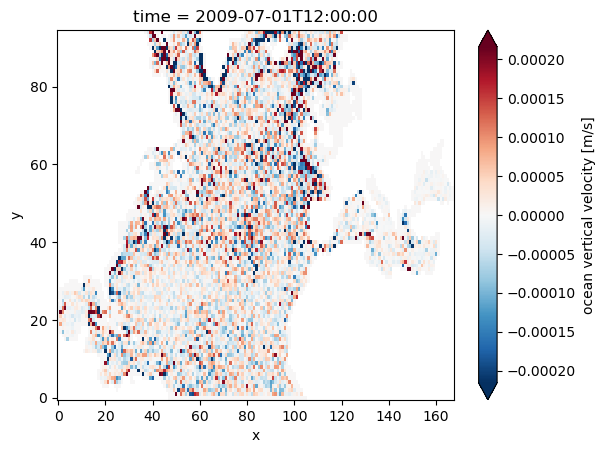

In [4]:
ds.vovecrtz.isel(time=0, x=slice(0,None, 50), y=slice(0,None, 50)).plot(robust=True)

In [ ]:
factor = 5
make_movie(ds.isel(x=slice(0,None, factor), y=slice(0,None, factor)), 
           'vovecrtz', 'RdBu', [-2e-4,2e-4],
           f"testing_eNATL", preview=False)

/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')


  0%|          | 0/291 [00:00<?, ?it/s]

/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  da = ds.isel({'time':t, x_dim:slice(None, None, subsample), y_dim:slice(None, None, subsample)}).drop('time')
/tmp/ipykernel_1239/3459860648.py:56: DeprecationWarning: dropping varia